## 1. Get Cross-Validation Result Table and Confusion Matrix for 7 Different Models 

In [1]:
# Load Necessary Libs and Read Data 
import os 
import numpy as np 
import pandas as pd 

def get_all_data( train_csv, val_csv ):
    
    train_data = pd.read_csv( train_csv )
    val_data = pd.read_csv( val_csv ) 
    vars = train_data.columns 
    print(vars)
    print( train_data.iloc[0] )
    # need to omit the first two columns as they're not normal variables ... 
    train_x, train_y = train_data[ vars[2:-1] ], train_data[ [vars[-1]] ]
    val_x, val_y = val_data[ vars[2:-1] ], val_data[ [vars[-1]] ] 
    xs, ys = pd.concat( [train_x, val_x], axis=0 ), pd.concat( [train_y, val_y], axis=0 )
    
    return xs, ys 


X, y = get_all_data( "train.csv", "val.csv" ) 
X, y = X.values, y.values

Index(['Unnamed: 0', 'ID', 'Gender', 'Age(y)', 'Diameter(mm)', 'Shape',
       'Margin', 'Cortex.size(mm)', 'Cortical.morphologic.features',
       'Nodal.echogenicity', 'Calcifications', 'Hilum', 'History.of.cancer',
       'Number.of.suspicious.axillary.lymphnodes',
       'Multiple.regions.of.suspicious.lymphnodes', 'Pathology'],
      dtype='object')
Unnamed: 0                                        415
ID                                           us713876
Gender                                              0
Age(y)                                             52
Diameter(mm)                                       29
Shape                                               0
Margin                                              0
Cortex.size(mm)                                    16
Cortical.morphologic.features                       2
Nodal.echogenicity                                  1
Calcifications                                      0
Hilum                                            

In [2]:
# specificity = TN/(TN+FP)
def get_spe( curr_conf ):
    return curr_conf[0,0] / ( curr_conf[0,0]+curr_conf[0,1] )

# NPV = TN/(TN+FN) 
def get_npv( curr_conf ):         
    return curr_conf[0,0] / ( curr_conf[0,0]+curr_conf[1,0] ) 

C:\Users\zhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\zhang\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

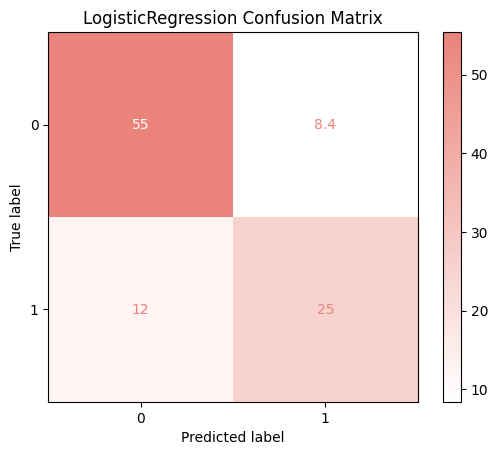

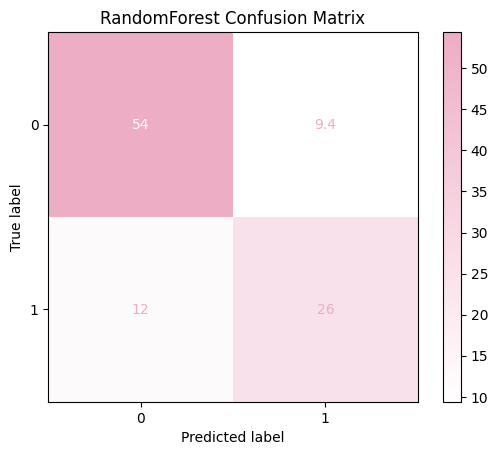

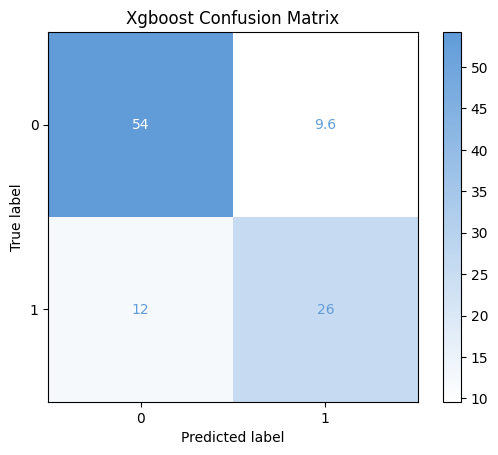

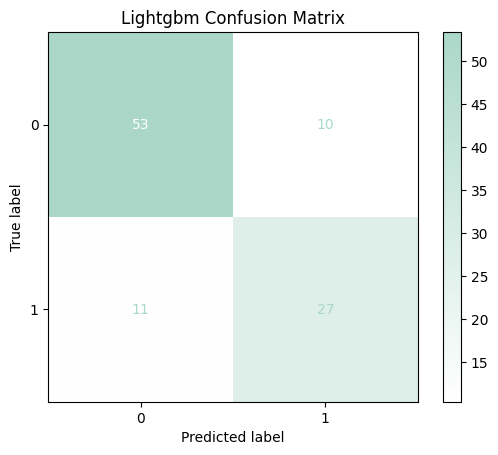

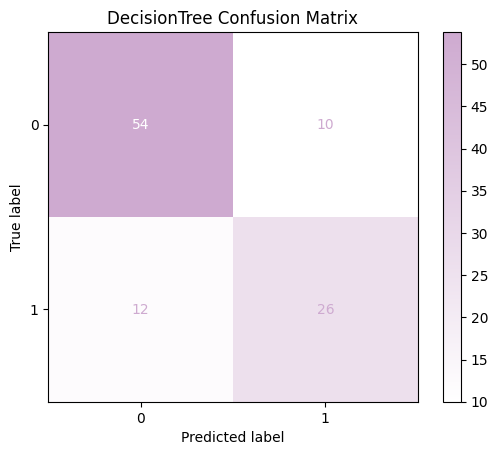

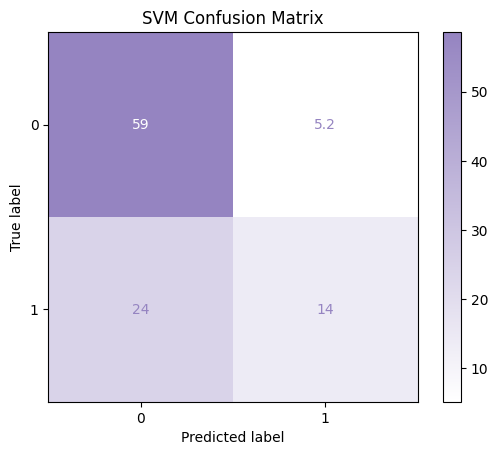

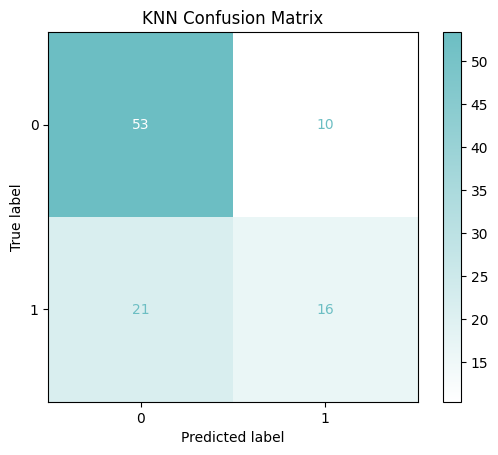

In [3]:
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import sklearn.metrics as metrics

import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
from sklearn.metrics import ConfusionMatrixDisplay 


def confusion_matrix_display( conf_mat, model_dict, selected_model, k, conf_folder ):

    start_color = np.array([255, 255, 255])     # white 
    end_color = np.array( model_dict[selected_model] )           # specified color 
    n_steps = 256                               # color transition 
    gradient = np.vstack([np.linspace(start_color[i], end_color[i], n_steps) for i in range(3)]).T
    gradient /= 255.0
    colormap = ListedColormap(gradient)

    disp = ConfusionMatrixDisplay(conf_mat, display_labels=["0", "1"])
    disp = disp.plot( cmap=colormap )
    plt.savefig( conf_folder + f"{selected_model}_{k}fold.jpg", bbox_inches='tight' ) 
    plt.title( "{} Confusion Matrix".format(selected_model) )
    plt.show() 

# func generate all models' cross-validation results 
def get_cv_result_table( X, y ):

    # create a folder to contain confusion matrix 
    conf_folder = "conf_mat_cv_res/"
    if not os.path.exists( conf_folder ):
        os.makedirs( conf_folder )
    # modify the RGB values for each model
    model_dict = { "LogisticRegression":[234, 131, 121], "RandomForest":[237, 173, 197], "Xgboost":[97, 156, 217], 
                "Lightgbm":[170, 215, 200], "DecisionTree":[206, 170, 208], "SVM":[149, 132, 193], "KNN":[108, 190, 195] }
    model_res = dict()

    # iterate to obtain the metrics' values of each selected model 
    for selected_model in model_dict:
        res = {}
        n_splits = 5
        cv = StratifiedKFold(n_splits=n_splits)
        accs, precs, recalls, specs, npvs, f1s, aucs = [], [], [], [], [], [], [] 
        conf_mat = np.zeros( (2,2) )   

        for fold, (train, test) in enumerate(cv.split(X, y)):
            if selected_model == "LogisticRegression":
                # model = LogisticRegression( max_iter=100, C=0.12, solver='newton-cg', penalty='l2' )
                model = LogisticRegression()
            if selected_model == "RandomForest":
                model = RandomForestClassifier()
                # model = RandomForestClassifier( criterion='gini', n_estimators=280, max_features='sqrt', max_depth=6 )
            if selected_model == "Xgboost":
                model = XGBClassifier()
                # model = XGBClassifier( eta=0.7, max_depth=7, min_child_weight=3 )
            if selected_model == "Lightgbm":
                model = LGBMClassifier(verbose=-1)
                # params = {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'nthread': 4, 'learning_rate': 0.01, 'n_estimators': 100, 'max_depth': 3, 'num_leaves': 10, 'subsample': 0.4, 'colsample_bytree': 1}
                # model = LGBMClassifier(**params, verbose=-1)
            if selected_model == "DecisionTree":
                model = tree.DecisionTreeClassifier()
            if selected_model == "SVM":
                model = svm.SVC( probability=True ) 
            if selected_model == "KNN":
                model = KNeighborsClassifier( 15 )
            
            train_y, test_y = np.reshape( y[train], (-1) ),  np.reshape( y[test], (-1) )
            model.fit( X[train], train_y )
            y_pred = model.predict( X[test] )
            probs=model.predict_proba( X[test] )[:,1]

            accs.append( accuracy_score( test_y, y_pred ) )
            precs.append( precision_score( test_y, y_pred, average="weighted" ) )
            recalls.append( recall_score( test_y, y_pred, average="weighted" ) )
            f1s.append( f1_score( test_y, y_pred, average="weighted" ) ) 
            aucs.append( metrics.roc_auc_score( test_y, probs, multi_class='ovr' ) ) # ovr - 0.7812; ovo - 0.7649
            
            curr_conf = confusion_matrix( test_y, y_pred ) 
            conf_mat += curr_conf

            specs.append( get_spe(curr_conf) ) 
            npvs.append( get_npv(curr_conf) )

        # rows' names
        # accuracy, precision, recall, f1 score, specificity (true negative rate), negative predictive rate 
        res = [ np.mean(accs), np.mean(precs), np.mean(recalls), np.mean(f1s), np.mean(specs), np.mean(npvs), np.mean(aucs) ] 
        model_res[ selected_model ] = res
        conf_mat /= n_splits
        confusion_matrix_display( conf_mat, model_dict, selected_model, n_splits, conf_folder ) 
    df = pd.DataFrame( data=model_res )
    df.rename( index={ 0:"acc", 1:"precision", 2:"recall", 3:"f1 score", 4:"specificity", 5:"negative predictive rate", 6:"auc" }, inplace=True )
    df.to_csv( "cv_res_table.csv" ) 

model_cv_res = get_cv_result_table( X, y )



## 2. For Our Selected Model, Train The Model with Training Set and Test with Validation Set

For this part, use random forest model for now.
1. Model Performance (train on training set and test on validation set);
2. Roc curve;
3. Calibration Curve;
4. Decision Curve Analysis (DCA);
5. Feature Correlation Map ... 

## 2.0. Get All Model Results on Validation Set

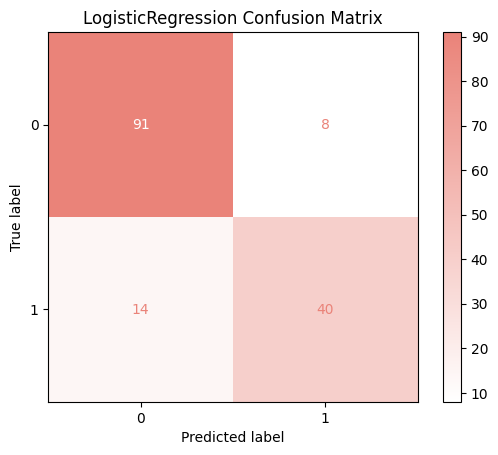

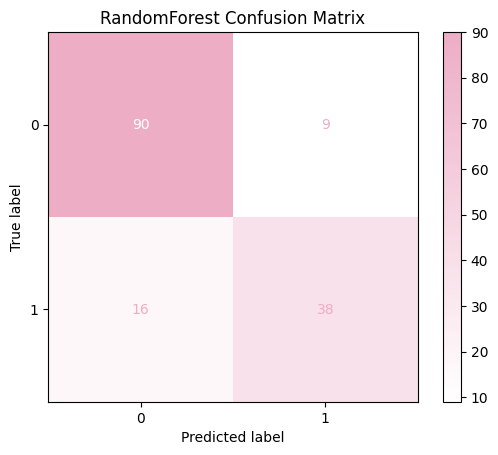

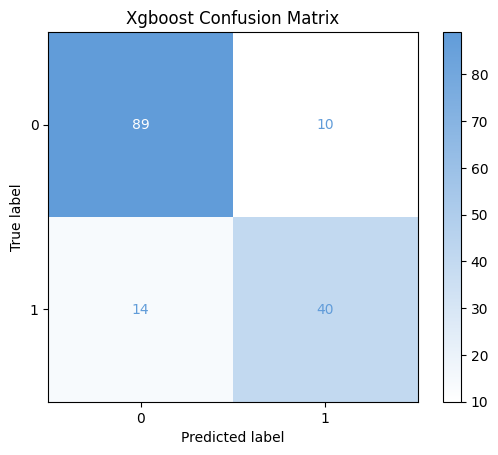

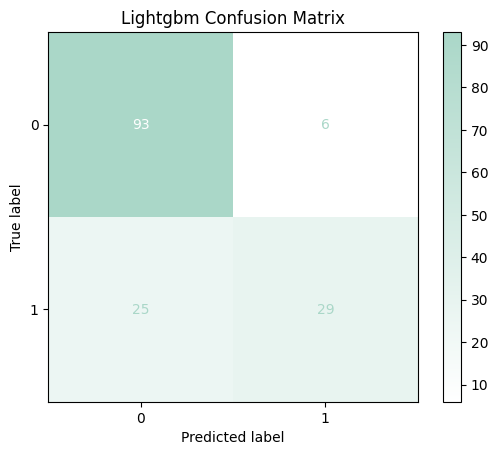

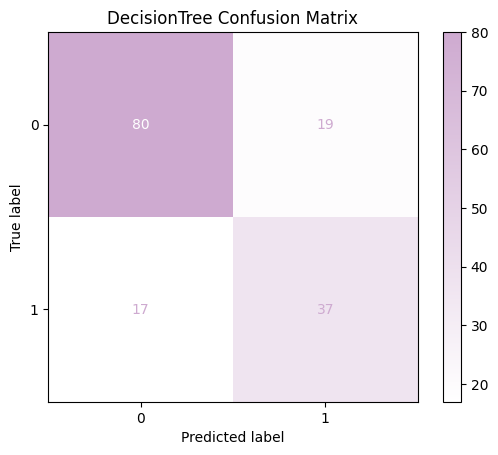

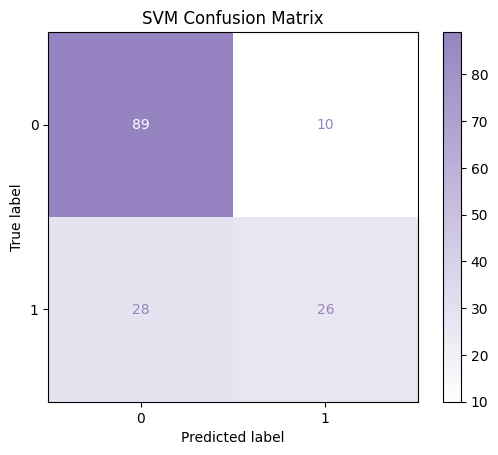

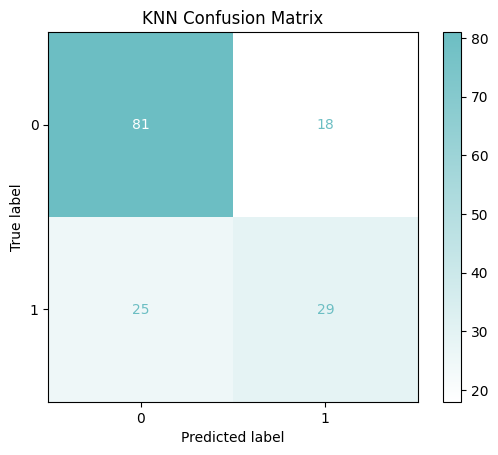

In [4]:
# get train or validation data 
def get_data( csv_file ):
    data = pd.read_csv( csv_file ) 
    vars = data.columns
    xs, ys = data[ vars[2:-1] ], data[ [vars[-1]] ]
    return xs, ys 

train_x, train_y = get_data( 'train.csv' )
val_x, val_y = get_data( 'val.csv' )
train_y = np.reshape( train_y.values, (-1) ) 
val_y = np.reshape( val_y.values, (-1) ) 

# func generate all models' cross-validation results 
def get_val_result_table( train_x, train_y, val_x, val_y ):

    # create a folder to contain confusion matrix 
    conf_folder = "conf_mat_val_res/"
    if not os.path.exists( conf_folder ):
        os.makedirs( conf_folder )
    # modify the RGB values for each model
    model_dict = { "LogisticRegression":[234, 131, 121], "RandomForest":[237, 173, 197], "Xgboost":[97, 156, 217], 
                "Lightgbm":[170, 215, 200], "DecisionTree":[206, 170, 208], "SVM":[149, 132, 193], "KNN":[108, 190, 195] }
    model_res = dict()

    # iterate to obtain the metrics' values of each selected model 
    for selected_model in model_dict:
        res = {}

        if selected_model == "LogisticRegression":
            model = LogisticRegression( max_iter=100, C=0.12, solver='newton-cg', penalty='l2' )
        if selected_model == "RandomForest":
            model = RandomForestClassifier( criterion='gini', n_estimators=280, max_features='sqrt', max_depth=6 )
        if selected_model == "Xgboost":
            model = XGBClassifier( eta=0.7, max_depth=7, min_child_weight=3 )
        if selected_model == "Lightgbm":
            params = {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'nthread': 4, 'learning_rate': 0.01, 'n_estimators': 100, 'max_depth': 3, 'num_leaves': 10, 'subsample': 0.4, 'colsample_bytree': 1}
            model = LGBMClassifier(**params, verbose=-1)
        if selected_model == "DecisionTree":
            model = tree.DecisionTreeClassifier()
        if selected_model == "SVM":
            model = svm.SVC( probability=True ) 
        if selected_model == "KNN":
            model = KNeighborsClassifier( 15 )
        
        model.fit( train_x, train_y ) 
        y_pred = model.predict( val_x )
        probs=model.predict_proba( val_x )[:,1]

        acc = accuracy_score( val_y, y_pred ) 
        prec = precision_score( val_y, y_pred, average="weighted" ) 
        recall = recall_score( val_y, y_pred, average="weighted" ) 
        f1 = f1_score( val_y, y_pred, average="weighted" )  
        auc = metrics.roc_auc_score( val_y, probs, multi_class='ovr' ) 
        
        curr_conf = confusion_matrix( val_y, y_pred ) 
        spec = get_spe(curr_conf) 
        npv = get_npv(curr_conf) 

        # rows' names
        # accuracy, precision, recall, f1 score, specificity (true negative rate), negative predictive rate 
        res = [ acc, prec, recall, f1, spec, npv, auc ] 
        model_res[ selected_model ] = res
        confusion_matrix_display( curr_conf, model_dict, selected_model, 1, conf_folder ) 
    df = pd.DataFrame( data=model_res )
    df.rename( index={ 0:"acc", 1:"precision", 2:"recall", 3:"f1 score", 4:"specificity", 5:"negative predictive rate", 6:"auc" }, inplace=True )
    df.to_csv( "val_res_table.csv" ) 

model_val_res = get_val_result_table( train_x, train_y, val_x, val_y )




### 2.1. ROC Curve

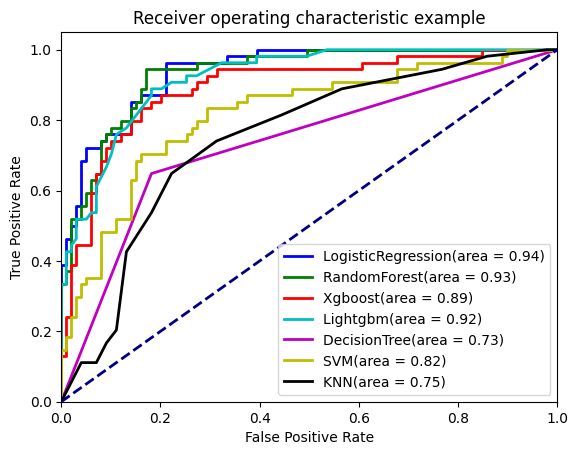

In [5]:
from sklearn.metrics import auc, roc_curve

# get the roc curve of 7 models 
def get_roc_curve( train_x, train_y, val_x, val_y ): 

    model_colors = { "LogisticRegression":'b', "RandomForest":'g', "Xgboost":'r', 
                "Lightgbm":'c', "DecisionTree":'m', "SVM":'y', "KNN":'k'}
    plt.figure()  # set up canvas ... 

    # iterate to obtain the metrics' values of each selected model 
    for selected_model in model_colors:

        if selected_model == "LogisticRegression":
            model = LogisticRegression( max_iter=100, C=0.12, solver='newton-cg', penalty='l2' )
        if selected_model == "RandomForest":
            model = RandomForestClassifier( criterion='gini', n_estimators=280, max_features='sqrt', max_depth=6 )
        if selected_model == "Xgboost":
            model = XGBClassifier( eta=0.7, max_depth=7, min_child_weight=3 )
        if selected_model == "Lightgbm":
            params = {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'nthread': 4, 'learning_rate': 0.01, 'n_estimators': 100, 'max_depth': 3, 'num_leaves': 10, 'subsample': 0.4, 'colsample_bytree': 1}
            model = LGBMClassifier(**params, verbose=-1)
        if selected_model == "DecisionTree":
            model = tree.DecisionTreeClassifier()
        if selected_model == "SVM":
            model = svm.SVC( probability=True ) 
        if selected_model == "KNN":
            model = KNeighborsClassifier( 15 )
        
        model.fit( train_x, train_y )
        y_score = model.predict_proba( val_x )[:,1]

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(2):
            fpr[i], tpr[i], _ = roc_curve(val_y, y_score)
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(val_y.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"]) 

        # Plot 
        lw = 2
        plt.plot(
            fpr[1],
            tpr[1],
            color= model_colors[selected_model] ,
            lw=lw,
            label= selected_model + "(area = %0.2f)" % roc_auc[1],)
        
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

model_val_res = get_roc_curve( train_x, train_y, val_x, val_y ) 



### 2.2. Selected Model's Result Metrics (train with training data and test with validation data)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


 acc is 0.8235294117647058,
 precision is 0.821132547760172,
 recall is 0.8235294117647058, 
 f1 score is 0.8204270068326776, 
 specificity is 0.898989898989899, 
 npv is 0.839622641509434, 
 auc is 0.9285447063224841.


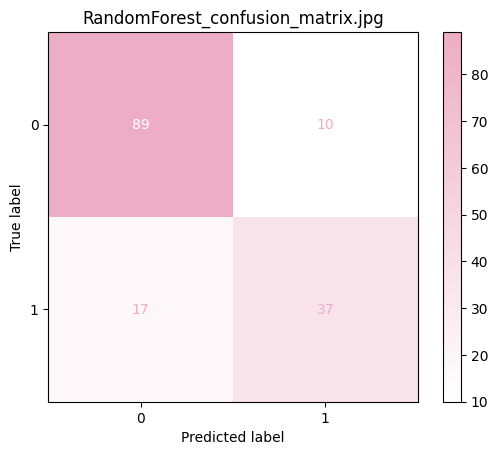

In [6]:
import shap
import numpy as np
import pandas as pd 
from matplotlib import colors as plt_colors

def confusion_matrix_display( conf_mat, model_dict, selected_model ):

    start_color = np.array([255, 255, 255])     # white 
    end_color = np.array( model_dict[selected_model] )           # specified color 
    n_steps = 256                               # color transition 
    gradient = np.vstack([np.linspace(start_color[i], end_color[i], n_steps) for i in range(3)]).T
    gradient /= 255.0
    colormap = ListedColormap(gradient)

    disp = ConfusionMatrixDisplay(conf_mat, display_labels=["0", "1"])
    disp = disp.plot( cmap=colormap )
    plt.title( f"{selected_model}_confusion_matrix.jpg" )
    plt.savefig( f"{selected_model}_confusion_matrix.jpg", bbox_inches='tight' ) 
    plt.show() 

model_dict = { "LogisticRegression":[234, 131, 121], "RandomForest":[237, 173, 197], "Xgboost":[97, 156, 217], 
                "Lightgbm":[170, 215, 200], "DecisionTree":[206, 170, 208], "SVM":[149, 132, 193], "KNN":[108, 190, 195] }

train_x, train_y = get_data( "train.csv" )
val_x, val_y = get_data( "val.csv" ) 
train_y, val_y = np.array(train_y).reshape(-1), np.array(val_y).reshape(-1)

selected_model = "RandomForest"

if selected_model == "LogisticRegression":
    model = LogisticRegression( penalty='l2', C=0.12, solver='newton-cg', max_iter=100 )
elif selected_model == "RandomForest":
    model = RandomForestClassifier( criterion='log_loss', n_estimators=280, max_features='log2', max_depth=6 )
elif selected_model == "Xgboost":
    model = XGBClassifier( eta=0.7, max_depth=7, min_child_weight=3 )
elif selected_model == "Lightgbm":
    params = {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'nthread': 4, 'learning_rate': 0.01, 'n_estimators': 100, 'max_depth': 3, 'num_leaves': 10, 'subsample': 0.4, 'colsample_bytree': 1}
    model = LGBMClassifier(**params, verbose=-1)
elif selected_model == "DecisionTree":
    model = tree.DecisionTreeClassifier()
elif selected_model == "KNN":
    model = KNeighborsClassifier( 5 )
elif selected_model == "SVM":
    model = svm.SVC( probability=True )

model.fit(train_x.values, train_y) 
model.fit( train_x, train_y )
y_pred = model.predict( val_x )
y_probs=model.predict_proba( val_x )[:,1]

acc = accuracy_score( val_y, y_pred ) 
precision = precision_score( val_y, y_pred, average="weighted" ) 
recall = recall_score( val_y, y_pred, average="weighted" ) 
f1 = f1_score( val_y, y_pred, average="weighted" ) 
auc = metrics.roc_auc_score( val_y, y_probs ) 
curr_conf = confusion_matrix( val_y, y_pred ) 
spec = get_spe(curr_conf) 
npv = get_npv(curr_conf) 

print( f" acc is {acc},\n precision is {precision},\n recall is {recall}, \n f1 score is {f1}, \n specificity is {spec}, \n npv is {npv}, \n auc is {auc}." )
confusion_matrix_display( curr_conf, model_dict, selected_model )

### 2.3 Calibration Curve 

============================== Calibration Curve ===============================


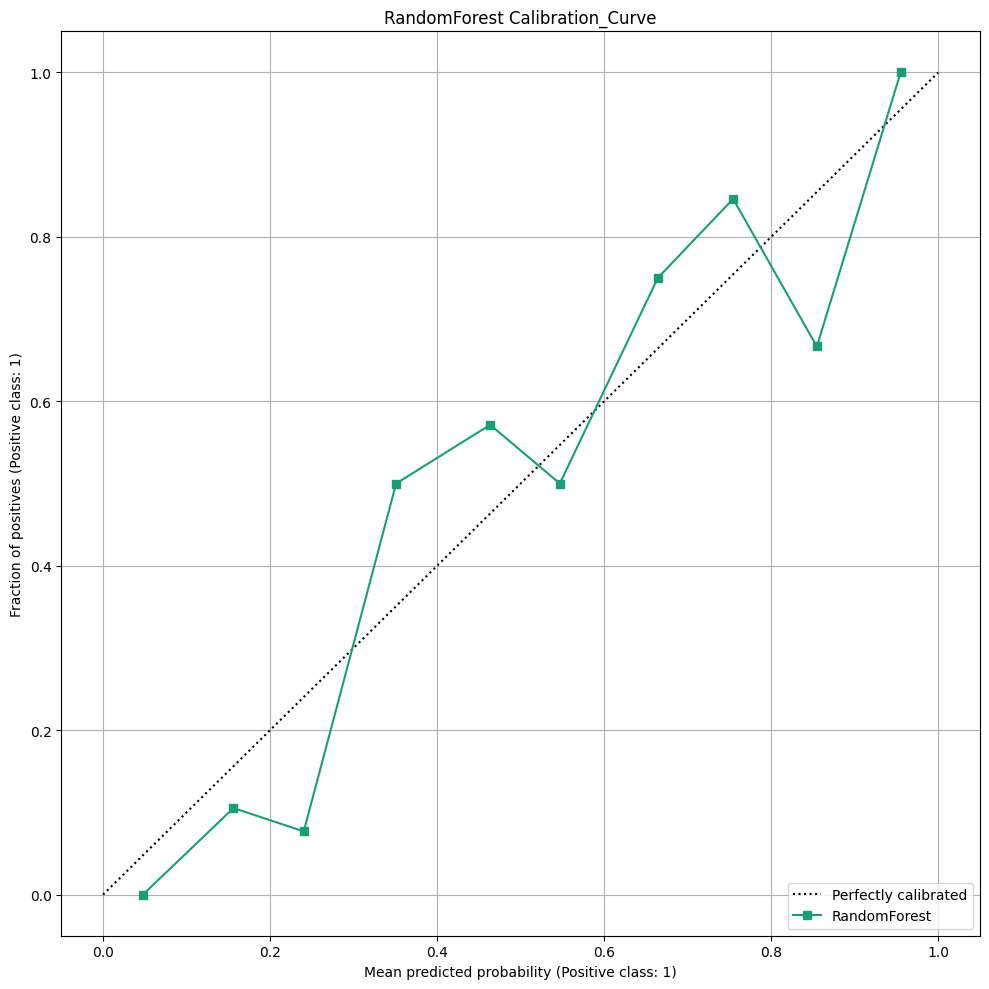

In [7]:
print('============================== Calibration Curve ===============================')
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

# clf_list = [(lg, "Logistic"),(lgb, "LightGBM"),(xgb, "XGBoost")]
clf_list = [ (model, selected_model) ]
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(train_x, train_y)
    display = CalibrationDisplay.from_estimator(
        clf,
        val_x,
        val_y,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration Plot")

plt.tight_layout()
plt.title( "{} Calibration_Curve".format(selected_model)  )
plt.savefig( "{} Calibration_Curve.jpg".format(selected_model) ) 
plt.show()

### 2.4 Decision Curve Analysis 

============================== Decision Curve Analysis ===============================


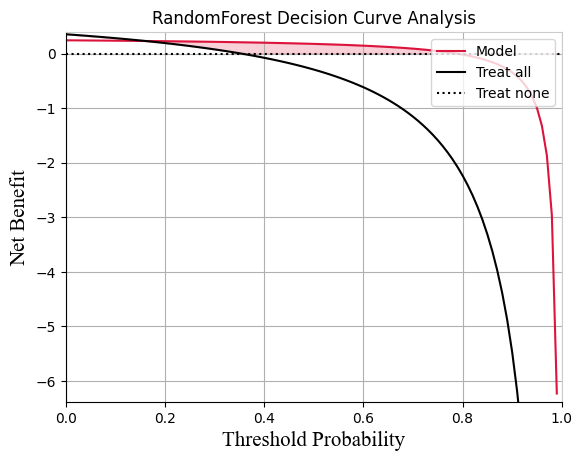

In [8]:
print('============================== Decision Curve Analysis ===============================')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def calculate_net_benefit_model(thresh_group, y_pred_score, y_label):
    net_benefit_model = np.array([])
    for thresh in thresh_group:
        y_pred_label = y_pred_score > thresh
        tn, fp, fn, tp = confusion_matrix(y_label, y_pred_label).ravel()
        n = len(y_label)
        net_benefit = (tp / n) - (fp / n) * (thresh / (1 - thresh))
        net_benefit_model = np.append(net_benefit_model, net_benefit)
    return net_benefit_model


def calculate_net_benefit_all(thresh_group, y_label):
    net_benefit_all = np.array([])
    tn, fp, fn, tp = confusion_matrix(y_label, y_label).ravel()
    total = tp + tn
    for thresh in thresh_group:
        net_benefit = (tp / total) - (tn / total) * (thresh / (1 - thresh))
        net_benefit_all = np.append(net_benefit_all, net_benefit)
    return net_benefit_all


def plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all):
    #Plot
    ax.plot(thresh_group, net_benefit_model, color = 'crimson', label = 'Model')
    ax.plot(thresh_group, net_benefit_all, color = 'black',label = 'Treat all')
    ax.plot((0, 1), (0, 0), color = 'black', linestyle = ':', label = 'Treat none')

    y2 = np.maximum(net_benefit_all, 0)
    y1 = np.maximum(net_benefit_model, y2)
    ax.fill_between(thresh_group, y1, y2, color = 'crimson', alpha = 0.2)

    #Figure Configuration， 美化一下细节
    ax.set_xlim(0,1)
    ax.set_ylim(net_benefit_model.min() - 0.15, net_benefit_model.max() + 0.15)#adjustify the y axis limitation
    ax.set_xlabel(
        xlabel = 'Threshold Probability', 
        fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
    ax.set_ylabel(
        ylabel = 'Net Benefit', 
        fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
    ax.grid('major')
    ax.spines['right'].set_color((0.8, 0.8, 0.8))
    ax.spines['top'].set_color((0.8, 0.8, 0.8))
    ax.legend(loc = 'upper right')

    return ax

y_pred_score = model.predict(val_x)
thresh_group = np.arange(0,1,0.01)
net_benefit_model = calculate_net_benefit_model(thresh_group, y_pred_score, val_y)
net_benefit_all = calculate_net_benefit_all(thresh_group, val_y)
fig, ax = plt.subplots()
ax = plot_DCA(ax, thresh_group, net_benefit_model, net_benefit_all)
ax.set_title("{} Decision Curve Analysis".format(selected_model))
plt.savefig( "{} Decision Curve Analysis.jpg".format(selected_model) ) 
plt.show()

### 2.5 Feature Correlation Heatmap 

(13, 13)


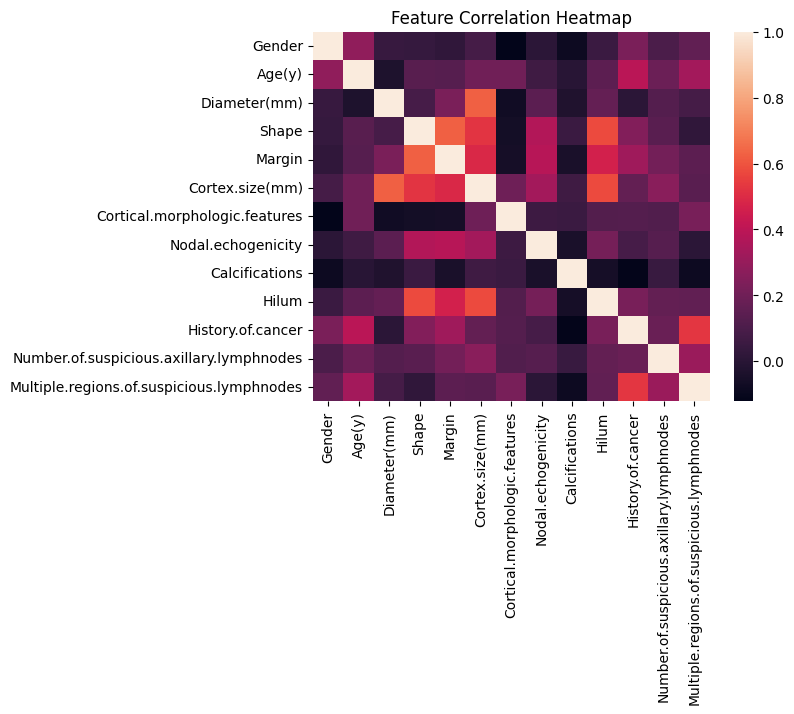

In [9]:
import seaborn as sn 
import matplotlib.pyplot as plt 

corr = val_x.corr() 
print( corr.shape )
ax = sn.heatmap(corr)
plt.title( "Feature Correlation Heatmap" )
plt.savefig( "Feature Correlation Heatmap.jpg" ) 